# Make trigger efficiency plots
- loads an output pkl file porcessed by the `trigger_efficiencies_processor.py` June 25th iteration
- makes trigger efficiency plots

In [3]:
import glob
import json
import os
import pickle
import pickle as pkl

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import yaml
from hist.intervals import clopper_pearson_interval
from scipy.special import softmax
from sklearn.metrics import auc, roc_curve

pd.options.mode.chained_assignment = None

plt.rcParams.update({"font.size": 20})
plt.style.use(hep.style.CMS)

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
trg_dict, var_dict, weight_dict = {}, {}, {}

with open("trigger_efficiency_plots_muons/0-100.pkl", "rb") as f:
    out = pkl.load(f)["2017"]["GluGluHToWW_Pt-200ToInf_M-125"]["skimmed_events"]
    
    channels = out.keys()
    
    for ch in channels:
        trg_dict[ch] = out[ch]["triggers"]
        var_dict[ch] = out[ch]["vars"]
        weight_dict[ch] = out[ch]["weights"]
        
        # must reshape this var
        var_dict[ch]["fj_genH_pt"] = var_dict[ch]["fj_genH_pt"].reshape(-1)

# Lepton kinematics

In [37]:
outdir = f"/Users/fmokhtar/Desktop/AN_2024/trigger/"

if not os.path.exists(outdir):
    os.makedirs(outdir)

In [38]:
nice_channel = {
    "ele": "Electron",
    "mu": "Muon",
}

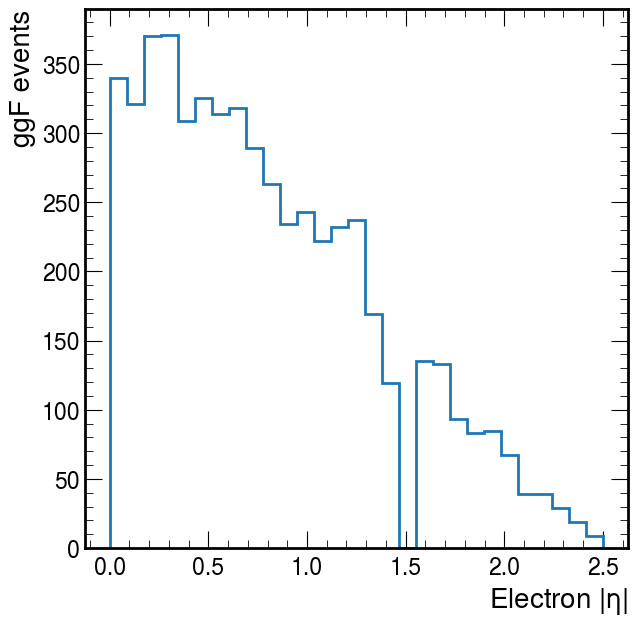

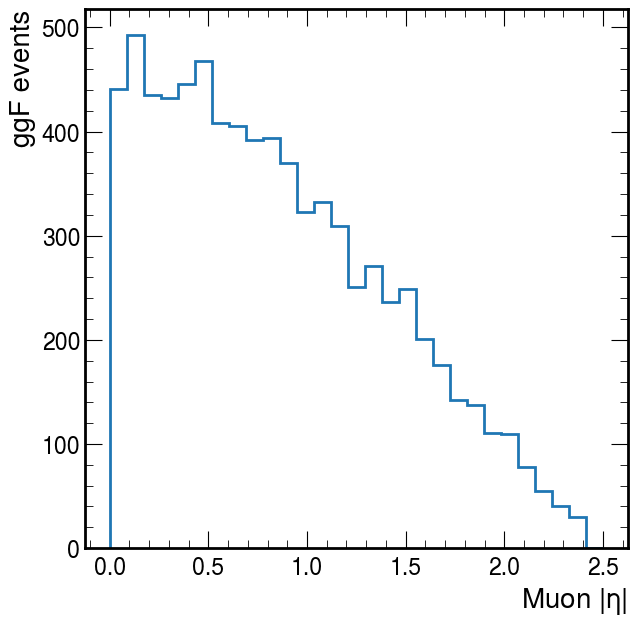

In [39]:
for ch in channels:
    fig, ax = plt.subplots(figsize=(7,7))

    ax.hist(
        abs(var_dict[ch]["lep_eta"]),
        bins=np.linspace(0,2.5,30),
        histtype="step",
        lw=2,
    )

    ax.set_xlabel(nice_channel[ch] + r" $|\eta|$")
    ax.set_ylabel("ggF events");

    plt.savefig(f"{outdir}/{ch}_eta.pdf")

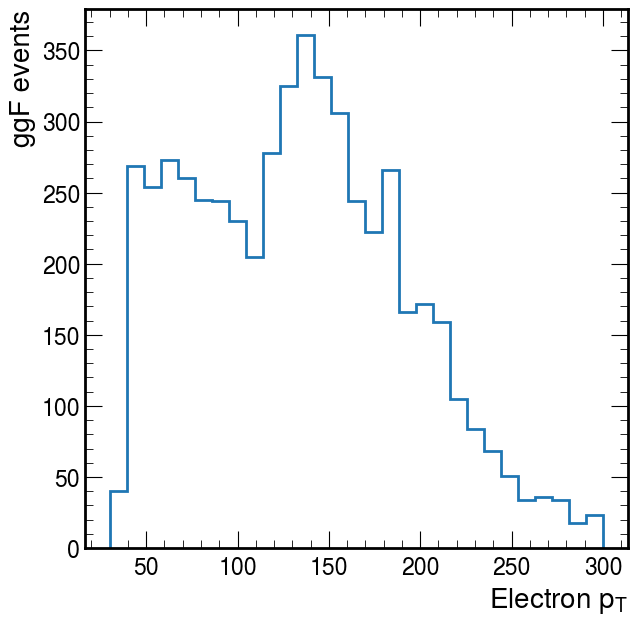

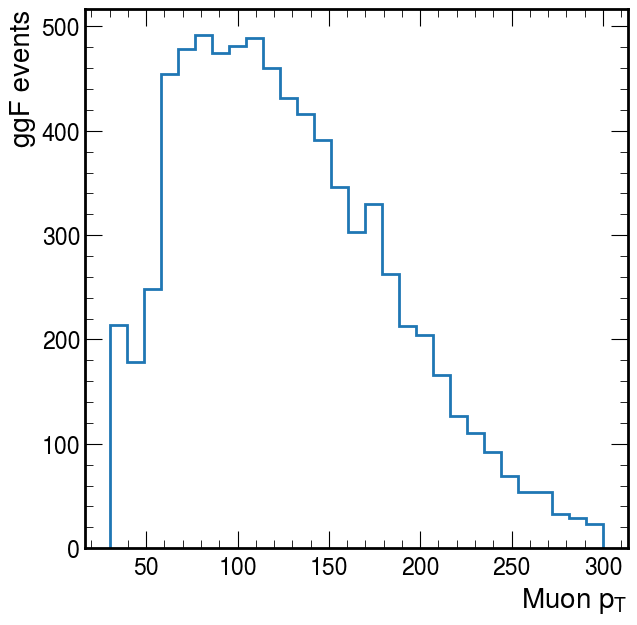

In [40]:
for ch in channels:

    fig, ax = plt.subplots(figsize=(7,7))

    ax.hist(
        var_dict[ch]["lep_pt"],
        bins=np.linspace(30,300,30),
        histtype="step",
        lw=2,
    )

    ax.set_xlabel(nice_channel[ch] + r" $p_T$")
    ax.set_ylabel("ggF events");

    plt.savefig(f"{outdir}/{ch}_pt.pdf")

# 1d efficiency plots

In [41]:
trg_dict

{'ele': {'HLT_ele35': array([False,  True,  True, ..., False, False,  True]),
  'HLT_ele115': array([False, False,  True, ...,  True,  True,  True]),
  'HLT_Photon200': array([False,  True, False, ..., False,  True,  True])},
 'mu': {'HLT_Mu50': array([ True,  True, False, ...,  True,  True,  True]),
  'HLT_IsoMu27': array([False,  True, False, ..., False,  True,  True]),
  'HLT_OldMu100': array([ True,  True, False, ...,  True,  True,  True]),
  'HLT_TkMu100': array([ True,  True, False, ...,  True,  True,  True])}}

In [42]:
hists = {}
msk_trg = {}

for ch in channels:
    hists[ch] = hist2.Hist(
        hist2.axis.StrCategory([], name='trigger', growth=True),
        hist2.axis.Regular(4, 0, 2.5, name='lepeta', label=r'Lepton $|\eta|$ [GeV]'),
        hist2.axis.Regular(30, 30, 300, name='leppt', label=r'Lepton $p_T$ [GeV]'),
        hist2.axis.Regular(30, 30, 300, name='higgspt', label=r'Gen Higgs $p_T$ [GeV]'),
    )

    # save events after each trigger
    for trg in trg_dict[ch]:
        hists[ch].fill(
            trigger=trg,
            leppt=var_dict[ch]["lep_pt"][trg_dict[ch][trg]],
            lepeta=abs(var_dict[ch]["lep_eta"])[trg_dict[ch][trg]],            
            higgspt=var_dict[ch]["fj_genH_pt"][trg_dict[ch][trg]],
        )

    # save events before trigger        
    hists[ch].fill(
        trigger="before_triggers",
        leppt=var_dict[ch]["lep_pt"],
        lepeta=abs(var_dict[ch]["lep_eta"]),
        higgspt=var_dict[ch]["fj_genH_pt"],        
    )

    
    ########## build the OR of all triggers
    msk_trg[ch] = np.zeros(len(var_dict[ch]["lep_pt"]), dtype="bool")

    for trig in trg_dict[ch]:
        msk_trg[ch] = msk_trg[ch] | trg_dict[ch][trig]
    
    # save an events before trigger        
    hists[ch].fill(
        trigger="or_of_triggers",
        leppt=var_dict[ch]["lep_pt"][msk_trg[ch]],
        lepeta=abs(var_dict[ch]["lep_eta"])[msk_trg[ch]],
        higgspt=var_dict[ch]["fj_genH_pt"][msk_trg[ch]],
    )

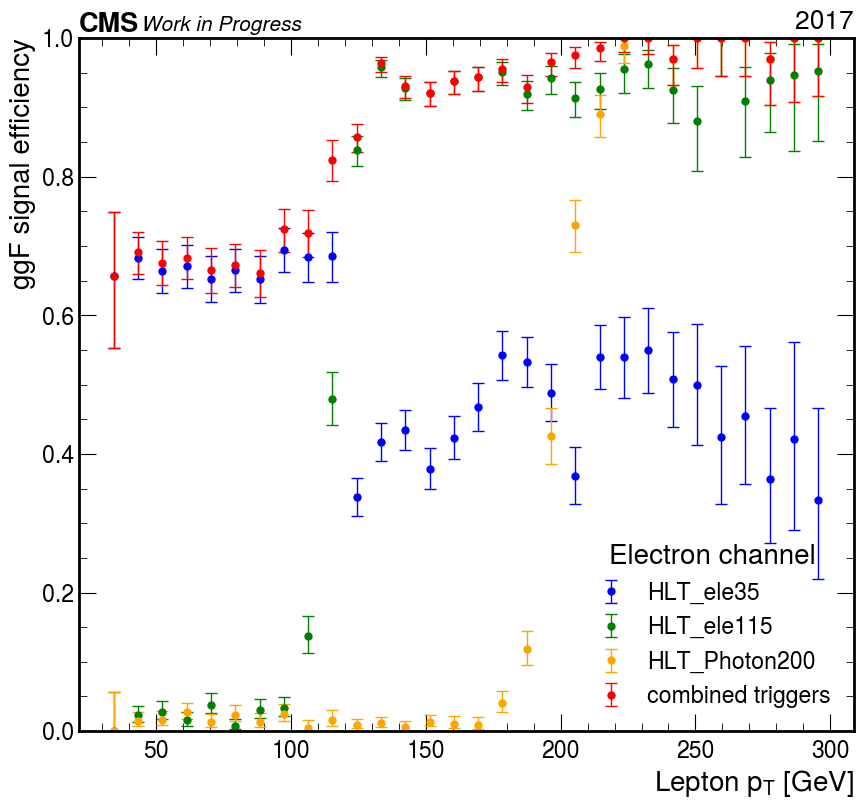

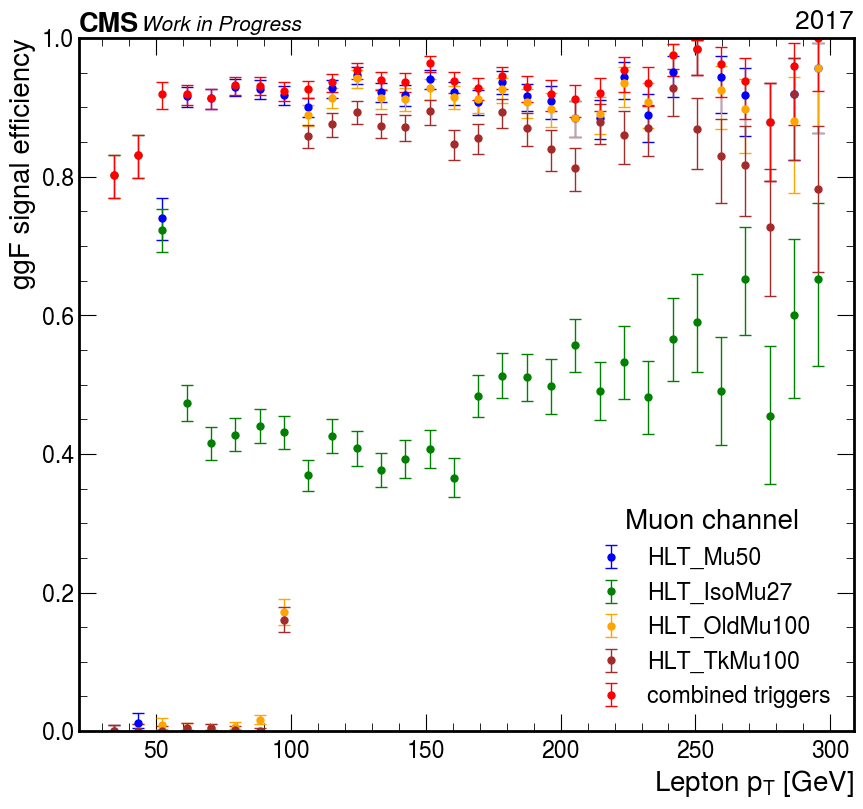

In [43]:
plt.rcParams.update({"font.size": 20})

colors_dict = {
    "combined triggers": "red",
    "HLT_ele35": "blue",
    "HLT_ele115": "green",
    "HLT_Photon200": "orange",
    
    "HLT_Mu50": "blue",
    "HLT_IsoMu27": "green",
    "HLT_OldMu100": "orange",    
    "HLT_TkMu100": "brown"
}

def get_yerr(num,den):
    return abs(clopper_pearson_interval(num.view(), den.view()) - num.view()/den.view())

for ch in channels:

    fig, ax = plt.subplots(figsize=(10,9))

    den = hists[ch][{"trigger": "before_triggers", 'higgspt':sum, 'lepeta': sum}]

    for trg in trg_dict[ch]:

        num = hists[ch][{"trigger": trg, 'higgspt':sum, 'lepeta': sum}]
        hep.histplot(num/den,
                     ax = ax,
                     label=trg,
                     color=colors_dict[trg],
                     histtype='errorbar', 
                     yerr=get_yerr(num, den),
                     capsize=4, 
                     elinewidth=1,
                     flow=None,
        )

    num = hists[ch][{"trigger": "or_of_triggers", 'higgspt':sum, 'lepeta': sum}]
    hep.histplot(num/den,
                 ax = ax,
                 label="combined triggers",
                 color=colors_dict["combined triggers"],                 
                 histtype='errorbar', 
                 yerr=get_yerr(num, den),
                 capsize=4, 
                 elinewidth=1,
                 flow=None,             
    )

    ax.set_ylim(0,1)
    ax.legend(title=f"{nice_channel[ch]} channel")
    ax.set_ylabel("ggF signal efficiency")
    hep.cms.lumitext(
        "2017", ax=ax, fontsize=20
    )
    hep.cms.text("Work in Progress", ax=ax, fontsize=15)

    plt.savefig(f"{outdir}/{ch}_trgeff_1d_leppt.pdf")